In [2]:
from matplotlib.mlab import griddata
import matplotlib.pyplot as plt

import pandas as pd 

import numpy as np
from numpy import linspace
from numpy import meshgrid
from numpy.random import uniform, seed

from mpl_toolkits.basemap import Basemap, shiftgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

title_sz = 27
axis_sz = 22
tick_sz = 21

from matplotlib.ticker import MaxNLocator
from matplotlib import cm, rcParams
rcParams.update({'font.size': tick_sz-4}) # Increase font-size
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib import gridspec

import pylab as pl

from sklearn import cluster, metrics
from sklearn.metrics import euclidean_distances, silhouette_samples, silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from oc_clustering_fxns import build_cluster_data, test_clustering
# from chem_ocean.oc_clustering_fxns import build_cluster_data, test_clustering
from oc_db_fxns import build_oc_station_db, make_arrays, min_max_print#, oc_data_2d

from itertools import islice
import sys, pickle, time, copy, re

%matplotlib inline

In [3]:
path = 'data/WOA13/' 
file_name = 'WOA13_annual.txt' #

file_path = path+file_name

In [4]:
def PDF_fig(_in_var_names, _lineDepth, _modelRaw, _sliceType, _plot_list):
    _varStr = ''.join([name[0] for name in _in_var_names])
    _name = _sliceType +str(_lineDepth)+ '_' + _modelRaw + '_' + _varStr + '.pdf'
    PDF_fig = PdfPages(_name)
    for plot in _plot_list:
        plot.savefig(PDF_fig, format='pdf')
    PDF_fig.close()

## Load Data

### Data is read into a Pandas DF

In [49]:
df_file = path+'WOA_df_sml.p'
df3 = pd.read_pickle(df_file)

### Limit spacial scale of DataFrame

In [50]:
#find stations that are within lat/lon bounds
(minLon, maxLon) = (-90., 20.)
(minLat, maxLat) = (-70., 15.)

df3_sub = df3.query('Latitude > '+str(minLat) +'and Latitude <'+ str(maxLat)+'and Longitude >' +str(minLon) + 'and Longitude <' + str(maxLon))
del df3

-*-*-
-*-*-

## Map Files

### Load map

In [51]:
def build_map2(show, proj, minLat, maxLat, minLon, maxLon, res, fig, ax, pos_num, labels_in):
    t0 = time.time()
    if proj in ['cyl', 'merc', 'mill', 'cea', 'gall', 'lcc']:
        _map = Basemap(projection=proj, lat_0 = (minLat+maxLat)*.5, lon_0 = (minLon+maxLon)*.5,
            resolution = res, area_thresh = 1,
            llcrnrlon=(minLon)*1, llcrnrlat=(minLat)*1,
            urcrnrlon=(maxLon)*1, urcrnrlat=(maxLat)*1)
    if proj in ['stere']:
        _map = Basemap(projection=proj, lat_0 = (minLat+maxLat)*.5, lon_0 = (minLon+maxLon)*.5,
            resolution = res, area_thresh = 1,
            llcrnrlon=(minLon)-30, llcrnrlat=(minLat)*1,
            urcrnrlon=(maxLon)*1, urcrnrlat=(maxLat)*1)
    if proj in ['ortho', 'geos', 'nsper']:
        _map = Basemap(projection=proj, lat_0 = (minLat+maxLat)*.5, lon_0 = (minLon+maxLon)*.5,
            resolution = res, area_thresh = 1,
            llcrnry=minLat*1,urcrnry=maxLat*1)#, llcrnrx=minLon*1, urcrnrx=maxLon*1, )
    else: 
        _map = Basemap(projection=proj, lat_0 = (minLat+maxLat)*.5, lon_0 = (minLon+maxLon)*.5,
            resolution = res, area_thresh = 1, llcrnrlon=(minLon)*1, llcrnrlat=(minLat)*1,
            urcrnrlon=(maxLon)*1, urcrnrlat=(maxLat)*1, rsphere=(6378137.00,6356752.3142))

    t1 = time.time()
#     print(1, t1-t0)
    if show == 'y':
        t0 = time.time()
        _map.ax = ax
        t1 = time.time()
        _map.drawcoastlines(color='k')
        _map.drawcountries()
        _map.fillcontinents(lake_color='b',color = 'gray')
        _map.drawmapboundary(linewidth=2)
        
        # labels = [left,right,top,bottom]
        lbls = []
        for label in ['l','r','t','b']:
            if label in labels_in:
                lbls.append(1)
            else:
                lbls.append(0)
            
        _map.drawmeridians(np.arange(0, 360, 30), labels=lbls)
        _map.drawparallels(np.arange(-90, 90, 30), labels=lbls)    
        t2 = time.time()
#     plt.savefig('/static/temp_map.png', dpi=200)
    return _map, fig, ax

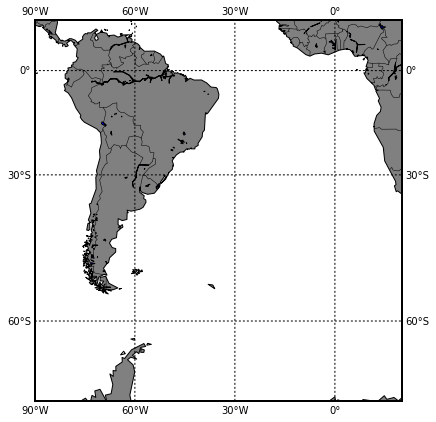

In [52]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(13, 7), facecolor='w')
_map, map_fig, ax = build_map2('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax1, 111, 'lrbt')

In [9]:
map_file = _map

-*-*-
-*-*-

# Raw data visualization and Clustering

### Data Prep

In [10]:
# Helper function to query DataFrame for slice of interest
def dfQueryFunc(_df3_sub, _var_names,**kwargs):
    basic = ['Station', 'Longitude', 'Latitude']
    if 'Depth' in _var_names:
        sum_names = basic +_var_names
    else: 
        sum_names = basic + ['Depth'] + _var_names
        
    if 'Depth' in kwargs:
        depth_target = kwargs['Depth']
        _var_df = _df3_sub[sum_names].query('Depth == '+str(depth_target))
    if 'Latitude' in kwargs:
        lat_target = kwargs['Latitude']
        (lonMin, lonMax) = kwargs['lonLimits']
        _var_df = _df3_sub[sum_names].query('Latitude >= '+str(lat_target-3)+ 'and Latitude <= '+str(lat_target+3)+ ' and Longitude >= '+str(lonMin)+ 'and Longitude <= '+str(lonMax))
    if 'Longitude' in kwargs:
        lon_target = kwargs['Longitude']
        (latMin, latMax) = kwargs['latLimits']
        _var_df = _df3_sub[sum_names].query('Longitude >= '+str(lon_target-3)+ 'and Longitude <= '+str(lon_target+3) +' and Latitude >= '+str(latMin)+ 'and Latitude <= '+str(latMax))
    return _var_df

In [11]:
# Returns data for specific variables for relevant spatial constraints 
# uses: dfQueryFunc
def amassData(_df_sub, _in_var_names, _sliceType, **kwargs):
    # Depth slice
    if _sliceType == 'plan':
        if 'depth' in kwargs:
            _depth = kwargs['depth']
        else:
            _depth = 1500
    
        cluster_df = dfQueryFunc(_df_sub, _in_var_names, Depth = _depth)
        _x = cluster_df['Longitude'].as_matrix()
        _y = cluster_df['Latitude'].as_matrix()
    
        _xLab = 'Longitude (deg)'
        _yLab = 'Latitude (deg)'
        _basemap = map_file
        _latLon_params = None
    
    # North-South (longitudinal) slice 
    if _sliceType == 'NSsection':
        if 'lonTraj' in kwargs:
            _lonTraj = kwargs['lonTraj']
        else:
            _lonTraj = -15
      
        if 'latLimits' in kwargs:
            _latLims = kwargs['latLimits']
        else:
            _latLims = [-55, -35]
      
        cluster_df = dfQueryFunc(_df_sub, _in_var_names, Longitude = _lonTraj, latLimits = _latLims)
        _x = cluster_df['Latitude'].as_matrix()
        _y = cluster_df['Depth'].as_matrix()
      
        _yLab = 'Depth (m)'  
        _xLab = 'Latitude (deg) along '+ r'%s $^\circ$' % abs(_lonTraj)+ ['W' if lon<0 else 'E' for lon in [_lonTraj]][0]
        _basemap = False
        _latLon_params = ((_lonTraj, _lonTraj), _latLims)
  
  # East-West (latitudeinal) slice
    if _sliceType == 'EWsection':
        if 'latTraj' in kwargs:
            _latTraj = kwargs['latTraj']
        else:
            _latTraj = -45
      
        if 'lonLimits' in kwargs:
            _lonLims = kwargs['lonLimits']
        else:
            _lonLims = [-10, 10]
      
        cluster_df = dfQueryFunc(_df_sub, _in_var_names, Latitude = _latTraj, lonLimits = _lonLims)
        _x = cluster_df['Longitude'].as_matrix()
        _y = cluster_df['Depth'].as_matrix()  
      
        _yLab = 'Depth (m))'  
        _xLab = 'Longitude (deg) along '+ r'%s $^\circ$' % abs(_latTraj)+ ['S' if lat<0 else 'N' for lat in [_latTraj]][0]
        _basemap = False
        _latLon_params = (_lonLims, [_latTraj, _latTraj])
  
    _feat_data = cluster_df[_in_var_names].as_matrix()
      
    mask = np.all(np.isnan(_feat_data), axis=1)
    _x = _x[~mask]
    _y = _y[~mask]
    _feat_data = _feat_data[~mask]
    
    if len(_in_var_names) == 1: 
        _feat_data = np.ravel(_feat_data)
  
    return _x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params

### Raw data visualization

In [12]:
units_dict = {'Temperature': '$^\circ$C', 'Oxygen': 'ml/l', 'AOU': 'ml/l', 'Longitude': '$^\circ$E', 'Salinity': '(psu)', 'Nitrate': '$\mu$mol/l', 'Depth': 'm', 'Phosphate': '$\mu$mol/l', 'Latitude': '$^\circ$N', 'Oxygen Saturation': '%'}

In [13]:
def make_section(ax, _colors, _x, _y, _latLon_params, model_raw):
    if model_raw == 'model':
        for im in range(len(_x)):
            ax.plot(_x[im], _y[im], c = _colors[im], marker = 'o', markersize=15, alpha = .1)

    ax.invert_yaxis()

    axin = inset_axes(ax, width="35%", height="35%", loc=4)
    inmap = Basemap(projection='ortho', lon_0=np.mean(_latLon_params[0]), lat_0=0,
        ax=axin, anchor='NE')
    inmap.fillcontinents()
    inmap.drawcoastlines(color='k')
    inmap.plot(_latLon_params[0], _latLon_params[1], '-k', linewidth=2 , latlon=True)  
    return ax

In [14]:
'''
Plots raw data either in section or plan.
If there is a basemap, x=lon, y=lat and data is from a depth slice (plan).
If not, x=lat or lon, y=depth.
Both plot types are colored by contour for a specific chemical constituent. 
'''
def plotRaw(_x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params, _in_var_names):
    if len(_feat_data.shape)>1:
        print( 'Please limit feature data to one variable')
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7), facecolor='w')
        if _basemap:
            _basemap, fig, ax = build_map2('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax, 111, 'lb')
            x_coord,y_coord = _basemap(_x, _y)
            cbar_pad = .22
            plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)
            ylabpad = 35
            xlabpad = 25
            plt.tight_layout(pad=0.4, w_pad=1., h_pad=1.0)


        else:
            x_coord = _x
            y_coord = _y
            ylabpad = 0
            xlabpad = 0

        # define grid.
        xi = np.linspace(min(x_coord), max(x_coord),300)
        yi = np.linspace(min(y_coord), max(y_coord),300)

        # grid the data.
        zi = griddata(x_coord,y_coord,_feat_data,xi,yi,interp='linear')

        # contour the gridded data, plotting dots at the nonuniform data points.
        CS = plt.contour(xi,yi,zi,10,linewidths=0.5,colors='k')
        CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.rainbow, 
                        vmax=abs(zi).max(), vmin=abs(zi).min())
        
        # label axes
        ax.set_ylabel(yLab, fontsize=axis_sz-3, labelpad = ylabpad)
        ax.set_xlabel(xLab, fontsize=axis_sz-3, labelpad = xlabpad)

        # reverse axis of y is depth
        if not _basemap:
            ax = make_section(plt.gca(), None, _x,_y, _latLon_params, 'raw')  
            cbar_pad = .22
        
        # create colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=cbar_pad)
        cbar = plt.colorbar(CS, cax=cax)
        cbar_label = _in_var_names[0] + ' (' + units_dict[_in_var_names[0]] + ')'
        cbar.ax.set_ylabel(cbar_label, fontsize=axis_sz) 
        
        # set tick size
        xtickNames = ax.get_xticklabels()
        ytickNames = ax.get_yticklabels()
        cbartickNames = cbar.ax.get_yticklabels()

        for names in [ytickNames, xtickNames, cbartickNames]:
            plt.setp(names, rotation=0, fontsize=tick_sz-4)

        plt.show()
        return fig

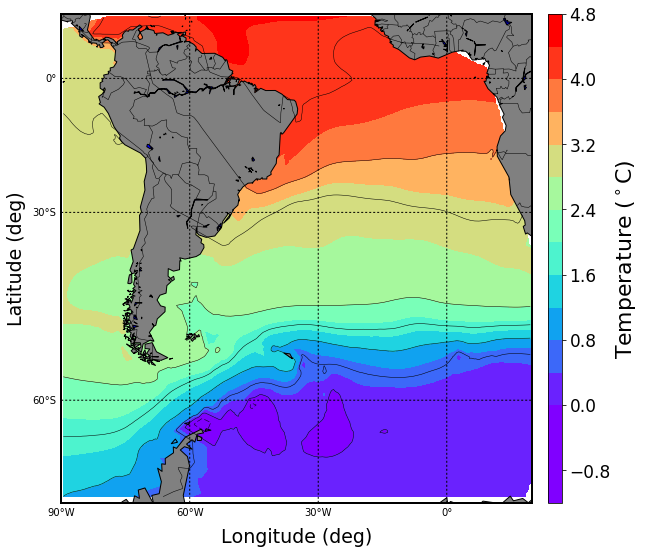

In [53]:
in_var_names = ['Temperature']
sliceType = 'plan'
lonLine = -15
x, y, feat_data, basemap, xLab, yLab, latLon_params = amassData(df3_sub, in_var_names, sliceType, lonTraj = lonLine, latLimits = (minLat, maxLat))
NSsection_fig = plotRaw(x, y, feat_data, basemap, xLab, yLab, latLon_params, in_var_names)

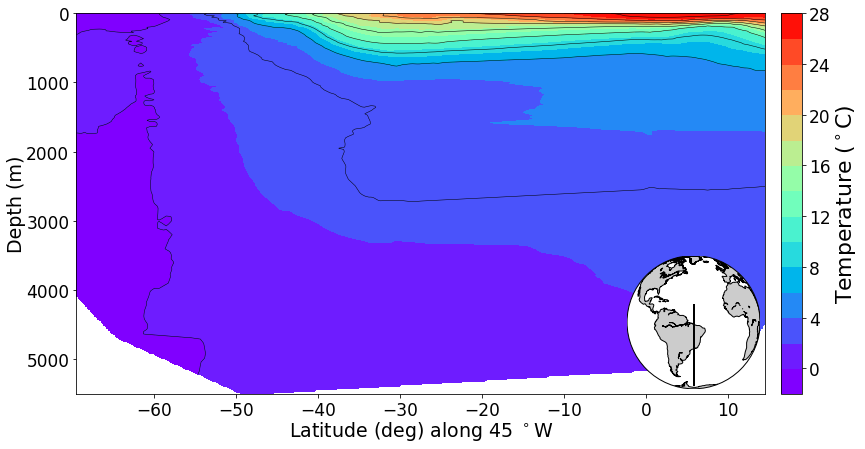

In [55]:
in_var_names = ['Temperature']
sliceType = 'NSsection'
lonLine = -45
x, y, feat_data, basemap, xLab, yLab, latLon_params = amassData(df3_sub, in_var_names, sliceType, lonTraj = lonLine, latLimits = (minLat, maxLat))
NSsection_fig = plotRaw(x, y, feat_data, False, xLab, yLab, latLon_params, in_var_names)
# PDF_fig(in_var_names, lonLine, 'raw', sliceType, [NSsection_fig])

## Predicting watermass distribution

### Apply clustering approaches 

*to passed data to generate a prediction of water masses at a specific depth based on perscribed chemical and state characteristics (e.g. temperature, salinity, nitrat concentration, phosphate concentration); returns figures of watermasses identified by color, drawn atop a map*

In [15]:
def test_clustering3(_x, _y, _data, _xLab, _yLab, N_CLUSTERS, _latLon_params, _basemp, **kwargs):
    pred_dict = {}
    np.random.seed(0)

    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)
    
    plot_num = 1
    X = _data
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # Compute distances
    # create clustering estimators
    alg_list = []
    for model in kwargs['models']:
        
        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        
        if model in ['Ward', 'AgglomerativeClustering']:
            # connectivity matrix for structured Ward
            connectivity = kneighbors_graph(X, n_neighbors=10)
            # make connectivity symmetric
            connectivity = 0.5 * (connectivity + connectivity.T)
            if model == 'Ward':
                ward = cluster.AgglomerativeClustering(n_clusters=N_CLUSTERS,
                                linkage='ward', connectivity=connectivity)
                alg_list.append(('Ward', ward))
            if model == 'AgglomerativeClustering':
                average_linkage = cluster.AgglomerativeClustering(linkage="average",
                                        affinity="cityblock", n_clusters=N_CLUSTERS,
                                        connectivity=connectivity)
                alg_list.append(('AgglomerativeClustering', average_linkage))
        if model == 'MiniBatchKMeans':
            two_means = cluster.MiniBatchKMeans(n_clusters=N_CLUSTERS)
            alg_list.append(('MiniBatchKMeans', two_means))
        if model == 'SpectralClustering':
            spectral = cluster.SpectralClustering(n_clusters=N_CLUSTERS,
                                              eigen_solver='arpack',
                                              affinity="nearest_neighbors")
            alg_list.append(('SpectralClustering', spectral))
        if model == 'DBSCAN':
            dbscan = cluster.DBSCAN(eps=.2)
            alg_list.append(('DBSCAN', dbscan))
        if model == 'AffinityPropagation':
            affinity_propagation = cluster.AffinityPropagation(damping=.9, preference=-200)
            alg_list.append(('AffinityPropagation', affinity_propagation))

    models = {}
    for name, algorithm in alg_list:
        models[name] = {}
        # predict cluster memberships
        models[name]['start'] = time.time()
        algorithm.fit(X)
        models[name]['end'] = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
            models[name]['y_pred']= y_pred
        else:
            y_pred = algorithm.predict(X)
            models[name]['y_pred']= y_pred

        models[name]['sil_score'] = metrics.silhouette_score(X, y_pred, metric='euclidean')
        models[name]['sample_sil_vals'] = silhouette_samples(X, y_pred)
        
        models[name]['model']= algorithm
        models[name]['N_CLUSTERS']= N_CLUSTERS

    return models

## Plot Model Output

In [33]:
def subplot_labels(_ax, _xLab, _yLab, xlabelpad, ylabelpad, tick_sz, axis_sz, _title, text_coord, text_note, text_note_sz, text_note_align):
    _ax.set_ylabel(_yLab, fontsize=axis_sz-3, labelpad = ylabelpad)
    _ax.set_xlabel(_xLab, fontsize=axis_sz-3, labelpad = xlabelpad)

    # set tick size
    xtickNames = _ax.get_xticklabels()
    ytickNames = _ax.get_yticklabels()

    plt.setp(ytickNames, rotation=0, fontsize=tick_sz-3)
    plt.setp(xtickNames, rotation=0, fontsize=tick_sz-3)

    _ax.set_title(_title, size=axis_sz)

    _ax.text(text_coord[0], text_coord[1],text_note, transform=plt.gca().transAxes, size=text_note_sz, horizontalalignment=text_note_align)


In [34]:
'''
Generates plots:
one (1) constant-depth slice ("plans") model output with sil coef plot
one (1) constant-lat or lon slice ("section") model output with sil coef plot

constant-depth slices ("plans") of multiple models (no sil coef plot)
constant-lat or lon slices ("section") of multiple models (no sil coef plot)
'''

def plot_model_output(_x, _y, _xLab, _yLab, _latLon_params, models, _sliceType, sil = "no"):
    pred_dict = {}
    np.random.seed(0)

    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)
    
    plot_num = 1
    NROWS = 1
    NCOLS = len(models)
    pos_num = 100+10*NCOLS+1
    
    if sil == 'no':
        if _sliceType == 'plan':
            fig = plt.figure(figsize=(17*NROWS, 17*NCOLS), facecolor='w')
        else:
            fig = plt.figure(figsize=(14*NROWS, 7*NCOLS), facecolor='w')
            
    for name, model_d in models.items():
        y_pred = model_d['y_pred']
        N_CLUSTERS = model_d['N_CLUSTERS']
        score = model_d['sil_score']
        t0 = model_d['start']
        t1 = model_d['end']
        sample_silhouette_values = model_d['sample_sil_vals']
        _colors = cm.spectral(y_pred.astype(float) / N_CLUSTERS)

        
        if sil == 'yes' and len(models) == 1:
            if _sliceType == "plan":
                figSize = (12, 8)
            else:
                figSize = (16, 7)
            fig, (ax1, ax2) = plt.subplots(nrows=len(models), ncols=2, figsize=figSize, facecolor='w')
            gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

            ax2 = plt.subplot(gs[1])
            ax2.set_xlim([-0.1, 1])
            ax2.set_ylim([0, len(sample_silhouette_values) + (N_CLUSTERS + 1) * 10])

            # Compute the silhouette scores for each sample
            sample_silhouette_values = model_d['sample_sil_vals']

            y_lower = 10
            for i in range(N_CLUSTERS):
                # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[y_pred == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.spectral(float(i) / N_CLUSTERS)
                ax2.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                # Label the silhouette plots with their cluster numbers at the middle
                ax2.text(-0.1, y_lower + 0.45 * size_cluster_i, str(i), size=axis_sz)

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            # The vertical line for average silhoutte score of all the values
            ax2.axvline(x=score, color="red", linestyle="--", linewidth=3)

            ax2.set_yticks([])  # Clear the yaxis labels / ticks
            ax2.set_xticks([ 0, .3, .6, .9])

            subplot_labels(ax2, "Silhouette Coefficient", "Cluster label", 0, 0, 
                           tick_sz, axis_sz, '', [.87, .90], 'avg.=\n'+ '%.2f' % score, tick_sz, 'center')

            _ylabpad = 35
            if _sliceType == 'plan':
                lbls_in = 'lb'
                _ylabpad = 35

                pos_num = 121

                _colors = cm.spectral(y_pred.astype(float) / N_CLUSTERS)
                pred_dict[name] = [_x, _y, colors[y_pred].tolist()] 

                _basemap, fig, ax = build_map2('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, plt.subplot(gs[0]), pos_num, lbls_in)
                x,y = _basemap(_x, _y)
                
                for im in range(len(x)):
                    _basemap.plot(x[im], y[im], color = _colors[im], marker = 'o', markersize=5, alpha = .3)    
                
                plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)
            
            else:
                # plot section 
                ax = make_section(plt.subplot(gs[0]), _colors, _x,_y, _latLon_params, 'model')

        else:
            pred_dict[name] = [_x, _y, colors[y_pred].tolist()]   
            lbls_in = 'lb'
            if _sliceType == 'plan':
                if plot_num == 1:
                    _ylabpad = 35
                else:
                    _yLab = ''
                    _ylabpad = 20
                    lbls_in = 'rb' if plot_num == NCOLS else 'b'
                        
                ax = plt.subplot(pos_num)
                _basemap, fig, ax = build_map2('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax, pos_num, lbls_in)
                x,y = _basemap(_x, _y)
                for im in range(len(x)):
                    _basemap.plot(x[im], y[im], color = _colors[im], marker = 'o', markersize=5, alpha = .3)  
                
                plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)

            else:
                ax = make_section(plt.subplot(pos_num), _colors, _x,_y, _latLon_params, 'model')

        subplot_labels(ax, _xLab, _yLab, 25, _ylabpad, tick_sz, axis_sz, name+ ', ' + '%.2f' % score,  [.99, .01], ('%.2fs' % (t1 - t0)).lstrip('0'), 12, 'right')

        plot_num += 1
        pos_num += 1
            
    plt.show()
    return pred_dict, fig    

In [56]:
# model options: ['Ward', 'AgglomerativeClustering', 'MiniBatchKMeans', 'SpectralClustering', 'DBSCAN', 'AffinityPropagation']

in_var_names = ['Oxygen', 'Phosphate', 'Salinity']
sliceType = 'plan'
Depth = 1500
x, y, feat_data, basemap, xLab, yLab, latLon_params = amassData(df3_sub, in_var_names, sliceType, depth = Depth)
N_CLUSTERS = 8
model_data = test_clustering3( x, y, feat_data, xLab, yLab, N_CLUSTERS, latLon_params, basemap, models = ['MiniBatchKMeans', 'Ward'])

This error is an interesting one and is discussed here:
https://github.com/scikit-learn/scikit-learn/issues/5327

FWIW, I tried 25 clusters and it still returned the warning. As a practical matter, oceanographers do not believe there to be this many distinct watermasses (as always, there are lumpers and splitters, but still), but watermasses do evolve as they move, and allowing for more clusters may highlight where those bodies have transitioned to a noticeably different set of traits. 

In [57]:
model_data1 = {'MiniBatchKMeans': model_data['MiniBatchKMeans']}
model_data2 = {'MiniBatchKMeans': model_data['MiniBatchKMeans'], 'Ward': model_data['Ward']}

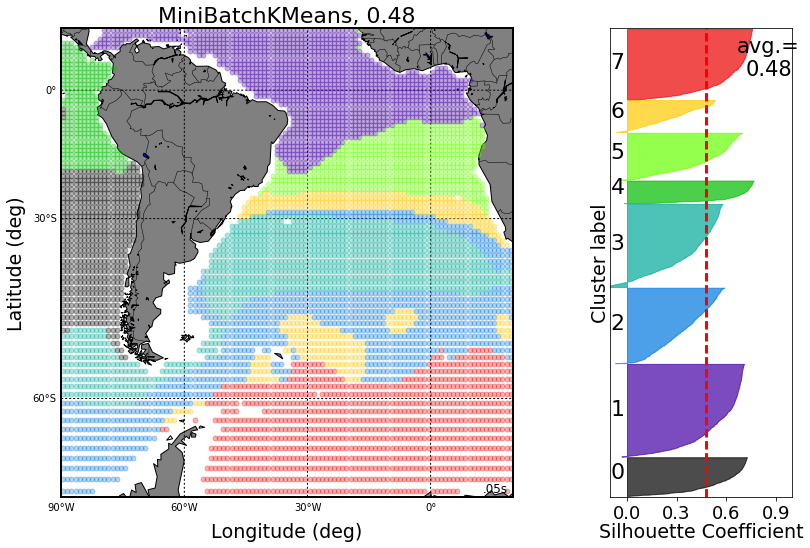

In [58]:
preds_dict, cluster_fig_SPO = plot_model_output(x, y, xLab, yLab, latLon_params, model_data1, sliceType, sil = "yes")

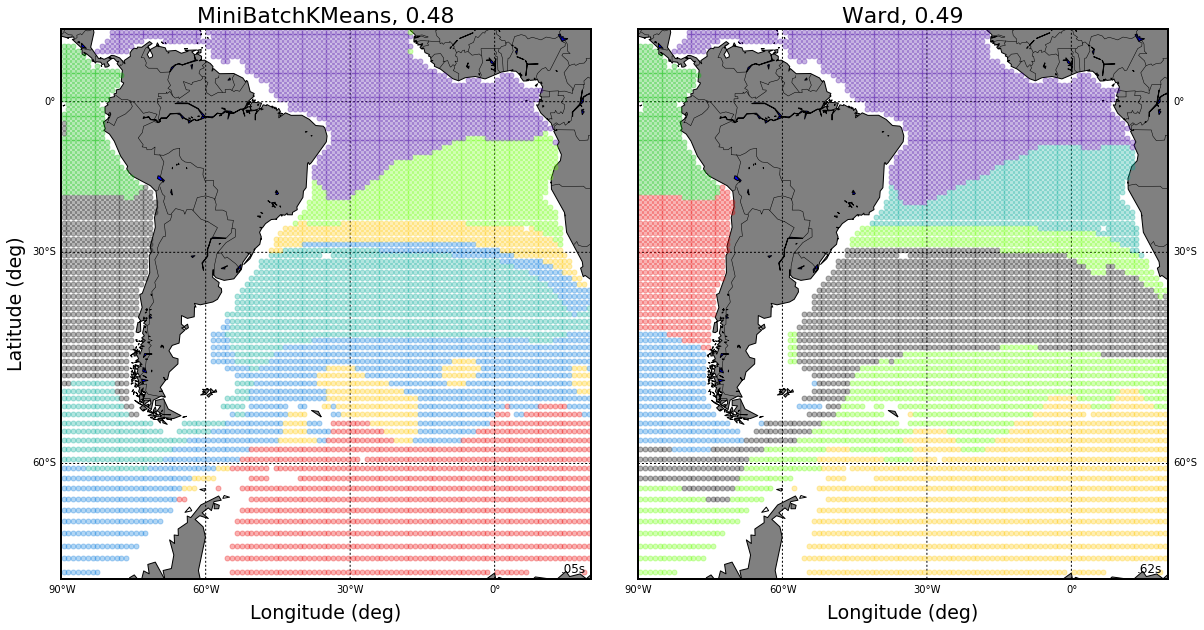

In [59]:
preds_dict, cluster_fig_SPO = plot_model_output(x, y, xLab, yLab, latLon_params, model_data2, sliceType, sil = "no")

### Section Plots

In [44]:
in_var_names = ['Oxygen', 'Phosphate']#, 'Oxygen', 'Temperature']
sliceType = 'NSsection'
lonLine = -15
x, y, feat_data, basemap, xLab, yLab, latLon_params = amassData(df3_sub, in_var_names, sliceType, depth = Depth)
N_CLUSTERS = 5
model_data = test_clustering3( x, y, feat_data, xLab, yLab, N_CLUSTERS, latLon_params, basemap, models = ['MiniBatchKMeans', 'Ward'])

In [45]:
model_data1 = {'MiniBatchKMeans': model_data['MiniBatchKMeans']}
model_data2 = {'MiniBatchKMeans': model_data['MiniBatchKMeans'], 'Ward': model_data['Ward']}

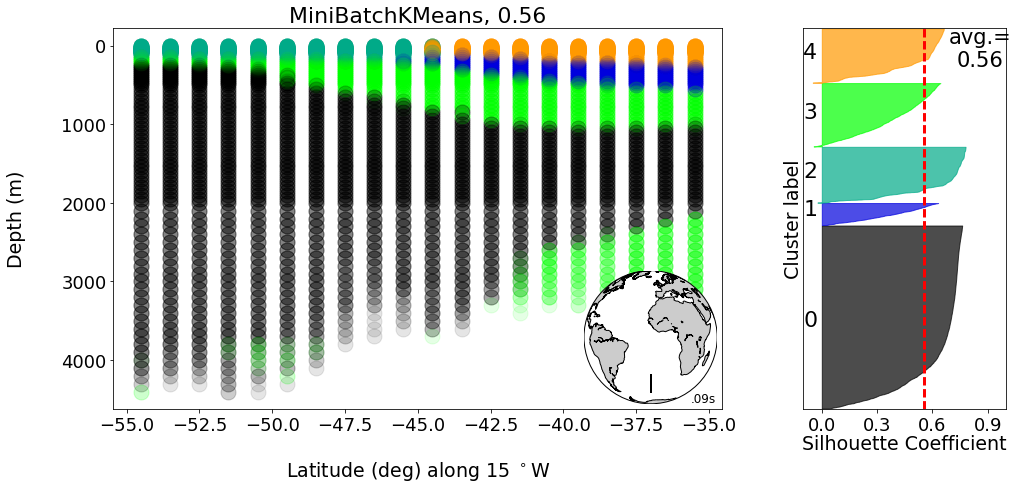

In [51]:
preds_dict, cluster_fig_SPO = plot_model_output(x, y, xLab, yLab, latLon_params, model_data1, sliceType, sil = "yes")

In [52]:
in_var_names = ['Salinity', 'Phosphate', 'Oxygen', 'Temperature']
sliceType = 'NSsection'
lonLine = -15
x, y, feat_data, basemap, xLab, yLab, latLon_params = amassData(df3_sub, in_var_names, sliceType, depth = Depth)
N_CLUSTERS = 4
model_data = test_clustering3( x, y, feat_data, xLab, yLab, N_CLUSTERS, latLon_params, basemap, models = ['MiniBatchKMeans', 'Ward'])
model_data1 = {'MiniBatchKMeans': model_data['MiniBatchKMeans']}

/usr/local/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


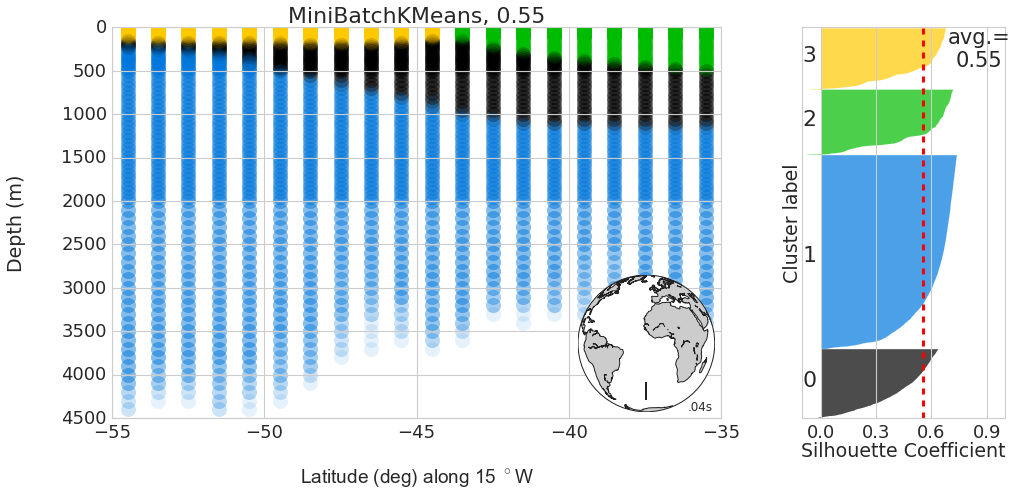

In [70]:
preds_dict, cluster_fig_SPO = plot_model_output(x, y, xLab, yLab, latLon_params, model_data1, sliceType, sil = "yes")

---